# Eksperimen Machine Learning: Wine Quality Prediction

**Author:** Syifa Fauziah  
**Course:** Membangun Sistem Machine Learning - Dicoding  
**Dataset:** UCI Wine Quality Dataset  
**Date:** December 2025

---

Notebook ini berisi tahapan lengkap eksperimen machine learning meliputi:

1. Import Libraries dan Konfigurasi
2. Data Loading dari UCI Repository
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing dan Feature Engineering
5. Data Splitting (Train/Test)
6. Feature Scaling
7. Export Data dan Artifacts

---
## Dataset Introduction

### Sumber Dataset
Dataset yang digunakan dalam proyek ini adalah **UCI Wine Quality Dataset** yang tersedia di:
- **Repository:** UCI Machine Learning Repository
- **URL:** https://archive.ics.uci.edu/ml/datasets/wine+quality
- **Referensi:** P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis (2009)

### Deskripsi Dataset
Dataset ini berisi hasil analisis physicochemical dari sampel wine dari Portugal utara:
- **Red Wine:** 1,599 sampel
- **White Wine:** 4,898 sampel  
- **Total:** 6,497 sampel setelah digabungkan

### Fitur Dataset (11 Input Variables)
| No | Fitur | Deskripsi | Satuan |
|----|-------|-----------|--------|
| 1 | fixed acidity | Asam tartarat dalam wine | g/dm³ |
| 2 | volatile acidity | Asam asetat dalam wine | g/dm³ |
| 3 | citric acid | Asam sitrat untuk kesegaran | g/dm³ |
| 4 | residual sugar | Gula tersisa setelah fermentasi | g/dm³ |
| 5 | chlorides | Kandungan garam | g/dm³ |
| 6 | free sulfur dioxide | SO2 bebas untuk antimikroba | mg/dm³ |
| 7 | total sulfur dioxide | Total SO2 | mg/dm³ |
| 8 | density | Kepadatan wine | g/cm³ |
| 9 | pH | Tingkat keasaman | - |
| 10 | sulphates | Aditif antimikroba | g/dm³ |
| 11 | alcohol | Kadar alkohol | % vol |

### Target Variable
- **quality:** Skor kualitas wine berdasarkan penilaian sensori
- **Skala:** 0 (sangat buruk) hingga 10 (sangat baik)
- **Distribusi aktual:** Mayoritas skor antara 5-7

### Tujuan Proyek
Membangun model machine learning untuk memprediksi kualitas wine berdasarkan karakteristik physicochemical-nya.

---
## 1. Import Libraries dan Konfigurasi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import json
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

RANDOM_STATE = 42
TEST_SIZE = 0.2

print('Libraries imported successfully')
print(f'Pandas version: {pd.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'Execution timestamp: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Libraries imported successfully
Pandas version: 2.2.2
NumPy version: 2.0.2
Execution timestamp: 2025-12-25 15:35:33


---
## 2. Data Loading

Dataset diambil dari UCI Machine Learning Repository. Dataset terdiri dari dua jenis wine:
- Red Wine (1599 samples)
- White Wine (4898 samples)

Kedua dataset digabungkan dengan menambahkan kolom `wine_type` sebagai identifier.

In [2]:
RED_WINE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
WHITE_WINE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

print('Fetching data from UCI Machine Learning Repository...')

try:
    df_red = pd.read_csv(RED_WINE_URL, sep=';')
    df_white = pd.read_csv(WHITE_WINE_URL, sep=';')
    print('Data fetched successfully from UCI repository')
except Exception as e:
    print(f'Error fetching data: {e}')
    raise

df_red['wine_type'] = 'red'
df_white['wine_type'] = 'white'

df = pd.concat([df_red, df_white], axis=0, ignore_index=True)

print(f'\nDataset Statistics:')
print(f'  Red wine samples: {len(df_red):,}')
print(f'  White wine samples: {len(df_white):,}')
print(f'  Total samples: {len(df):,}')
print(f'  Number of features: {len(df.columns) - 1}')

Fetching data from UCI Machine Learning Repository...
Data fetched successfully from UCI repository

Dataset Statistics:
  Red wine samples: 1,599
  White wine samples: 4,898
  Total samples: 6,497
  Number of features: 12


In [3]:
output_raw_dir = '../winequality_raw'
os.makedirs(output_raw_dir, exist_ok=True)

df.to_csv(f'{output_raw_dir}/winequality_combined.csv', index=False)
df_red.drop(columns=['wine_type']).to_csv(f'{output_raw_dir}/winequality_red.csv', index=False)
df_white.drop(columns=['wine_type']).to_csv(f'{output_raw_dir}/winequality_white.csv', index=False)

print(f'Raw data saved to {output_raw_dir}/')
print('Files created:')
for f in os.listdir(output_raw_dir):
    size = os.path.getsize(f'{output_raw_dir}/{f}') / 1024
    print(f'  - {f} ({size:.1f} KB)')

Raw data saved to ../winequality_raw/
Files created:
  - winequality_red.csv (89.8 KB)
  - winequality_white.csv (280.7 KB)
  - winequality_combined.csv (405.3 KB)


In [4]:
print('Dataset Shape:', df.shape)
print('\nColumn Names and Data Types:')
print('-' * 50)
for col in df.columns:
    print(f'  {col}: {df[col].dtype}')

Dataset Shape: (6497, 13)

Column Names and Data Types:
--------------------------------------------------
  fixed acidity: float64
  volatile acidity: float64
  citric acid: float64
  residual sugar: float64
  chlorides: float64
  free sulfur dioxide: float64
  total sulfur dioxide: float64
  density: float64
  pH: float64
  sulphates: float64
  alcohol: float64
  quality: int64
  wine_type: object


In [5]:
print('First 10 rows of the dataset:')
df.head(10)

First 10 rows of the dataset:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4000,0.7000,0.0000,1.9000,0.0760,11.0000,34.0000,0.9978,3.5100,0.5600,9.4000,5,red
1,7.8000,0.8800,0.0000,2.6000,0.0980,25.0000,67.0000,0.9968,3.2000,0.6800,9.8000,5,red
2,7.8000,0.7600,0.0400,2.3000,0.0920,15.0000,54.0000,0.9970,3.2600,0.6500,9.8000,5,red
3,11.2000,0.2800,0.5600,1.9000,0.0750,17.0000,60.0000,0.9980,3.1600,0.5800,9.8000,6,red
4,7.4000,0.7000,0.0000,1.9000,0.0760,11.0000,34.0000,0.9978,3.5100,0.5600,9.4000,5,red
5,7.4000,0.6600,0.0000,1.8000,0.0750,13.0000,40.0000,0.9978,3.5100,0.5600,9.4000,5,red
6,7.9000,0.6000,0.0600,1.6000,0.0690,15.0000,59.0000,0.9964,3.3000,0.4600,9.4000,5,red
7,7.3000,0.6500,0.0000,1.2000,0.0650,15.0000,21.0000,0.9946,3.3900,0.4700,10.0000,7,red
8,7.8000,0.5800,0.0200,2.0000,0.0730,9.0000,18.0000,0.9968,3.3600,0.5700,9.5000,7,red
9,7.5000,0.5000,0.3600,6.1000,0.0710,17.0000,102.0000,0.9978,3.3500,0.8000,10.5000,5,red


In [6]:
print('Dataset Info:')
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


---
## 3. Exploratory Data Analysis (EDA)

Tahap EDA meliputi analisis statistik deskriptif, pengecekan missing values dan duplikat, analisis distribusi target dan fitur, serta analisis korelasi antar variabel.

### 3.1 Descriptive Statistics

In [7]:
print('Descriptive Statistics for Numerical Features:')
desc_stats = df.describe().T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['cv'] = (desc_stats['std'] / desc_stats['mean']) * 100
desc_stats

Descriptive Statistics for Numerical Features:


,count,mean,std,min,25%,50%,75%,max,range,cv
fixed acidity,6497.0000,7.2153,1.2964,3.8000,6.4000,7.0000,7.7000,15.9000,12.1000,17.9678
volatile acidity,6497.0000,0.3397,0.1646,0.0800,0.2300,0.2900,0.4000,1.5800,1.5000,48.4701
citric acid,6497.0000,0.3186,0.1453,0.0000,0.2500,0.3100,0.3900,1.6600,1.6600,45.6066
residual sugar,6497.0000,5.4432,4.7578,0.6000,1.8000,3.0000,8.1000,65.8000,65.2000,87.4076
chlorides,6497.0000,0.0560,0.0350,0.0090,0.0380,0.0470,0.0650,0.6110,0.6020,62.5222
free sulfur dioxide,6497.0000,30.5253,17.7494,1.0000,17.0000,29.0000,41.0000,289.0000,288.0000,58.1465
total sulfur dioxide,6497.0000,115.7446,56.5219,6.0000,77.0000,118.0000,156.0000,440.0000,434.0000,48.8333
density,6497.0000,0.9947,0.0030,0.9871,0.9923,0.9949,0.9970,1.0390,0.0519,0.3015
pH,6497.0000,3.2185,0.1608,2.7200,3.1100,3.2100,3.3200,4.0100,1.2900,4.9957
sulphates,6497.0000,0.5313,0.1488,0.2200,0.4300,0.5100,0.6000,2.0000,1.7800,28.0096


In [8]:
print('Additional Statistics:')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

additional_stats = pd.DataFrame({
    'skewness': df[numeric_cols].skew(),
    'kurtosis': df[numeric_cols].kurtosis(),
    'median': df[numeric_cols].median(),
    'mode': df[numeric_cols].mode().iloc[0],
    'iqr': df[numeric_cols].quantile(0.75) - df[numeric_cols].quantile(0.25)
})
additional_stats

Additional Statistics:


,skewness,kurtosis,median,mode,iqr
fixed acidity,1.7233,5.0612,7.0000,6.8000,1.3000
volatile acidity,1.4951,2.8254,0.2900,0.2800,0.1700
citric acid,0.4717,2.3972,0.3100,0.3000,0.1400
residual sugar,1.4354,4.3593,3.0000,2.0000,6.3000
chlorides,5.3998,50.8981,0.0470,0.0440,0.0270
free sulfur dioxide,1.2201,7.9062,29.0000,29.0000,24.0000
total sulfur dioxide,-0.0012,-0.3717,118.0000,111.0000,79.0000
density,0.5036,6.6061,0.9949,0.9972,0.0047
pH,0.3868,0.3677,3.2100,3.1600,0.2100
sulphates,1.7973,8.6537,0.5100,0.5000,0.1700


### 3.2 Missing Values Analysis

In [9]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage (%)': missing_percentage
})

print('Missing Values Analysis:')
print('-' * 50)
if missing_values.sum() == 0:
    print('No missing values found in the dataset')
else:
    print(missing_df[missing_df['Missing Count'] > 0])

print(f'\nTotal missing values: {missing_values.sum()}')

Missing Values Analysis:
--------------------------------------------------
No missing values found in the dataset

Total missing values: 0


### 3.3 Duplicate Analysis

In [10]:
total_duplicates = df.duplicated().sum()
duplicate_percentage = (total_duplicates / len(df)) * 100

print('Duplicate Analysis:')
print('-' * 50)
print(f'Total duplicate rows: {total_duplicates:,}')
print(f'Percentage of duplicates: {duplicate_percentage:.2f}%')

if total_duplicates > 0:
    print('\nSample of duplicate rows:')
    display(df[df.duplicated(keep='first')].head())

Duplicate Analysis:
--------------------------------------------------
Total duplicate rows: 1,177
Percentage of duplicates: 18.12%

Sample of duplicate rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
4,7.4000,0.7000,0.0000,1.9000,0.0760,11.0000,34.0000,0.9978,3.5100,0.5600,9.4000,5,red
11,7.5000,0.5000,0.3600,6.1000,0.0710,17.0000,102.0000,0.9978,3.3500,0.8000,10.5000,5,red
27,7.9000,0.4300,0.2100,1.6000,0.1060,10.0000,37.0000,0.9966,3.1700,0.9100,9.5000,5,red
40,7.3000,0.4500,0.3600,5.9000,0.0740,12.0000,87.0000,0.9978,3.3300,0.8300,10.5000,5,red
65,7.2000,0.7250,0.0500,4.6500,0.0860,4.0000,11.0000,0.9962,3.4100,0.3900,10.9000,5,red


### 3.4 Target Variable Analysis (Quality)

In [11]:
print('Quality Score Distribution:')
quality_dist = df['quality'].value_counts().sort_index()
quality_pct = (quality_dist / len(df) * 100).round(2)

quality_analysis = pd.DataFrame({
    'Count': quality_dist,
    'Percentage (%)': quality_pct
})
print(quality_analysis)

Quality Score Distribution:
         Count  Percentage (%)
quality                       
3           30          0.4600
4          216          3.3200
5         2138         32.9100
6         2836         43.6500
7         1079         16.6100
8          193          2.9700
9            5          0.0800


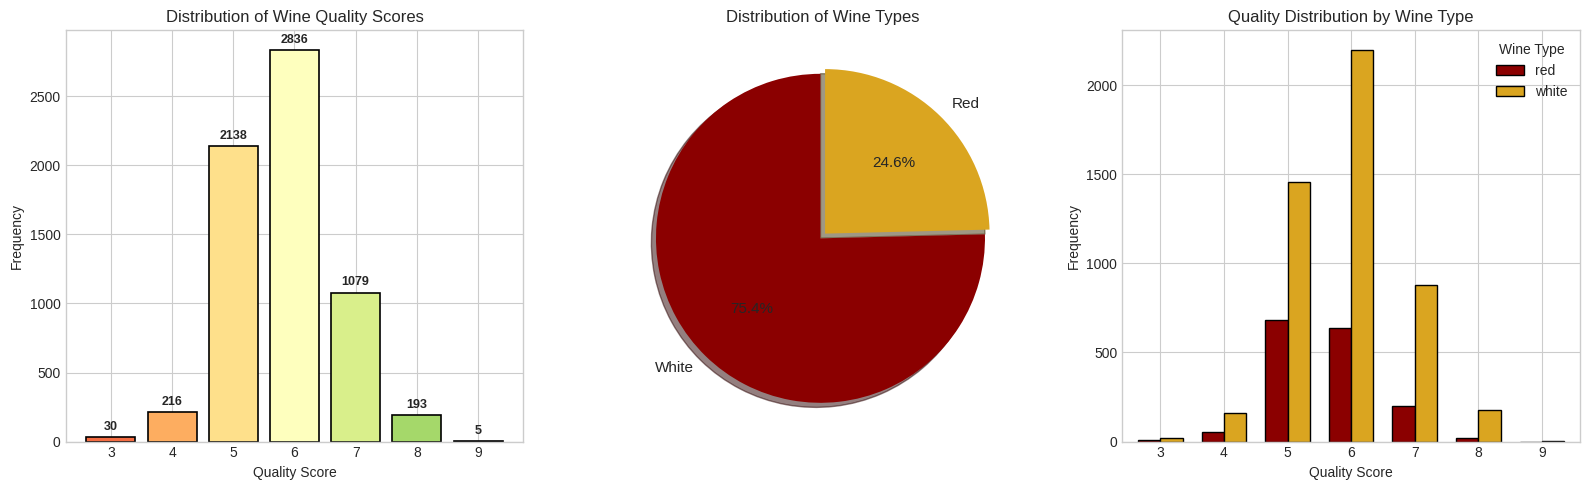

Figure saved: winequality_preprocessing/01_quality_distribution.png


In [12]:
output_dir = 'winequality_preprocessing'
os.makedirs(output_dir, exist_ok=True)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

quality_counts = df['quality'].value_counts().sort_index()
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(quality_counts)))
bars = axes[0].bar(quality_counts.index.astype(str), quality_counts.values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Quality Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Wine Quality Scores')
for bar, count in zip(bars, quality_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
                 str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')

wine_type_counts = df['wine_type'].value_counts()
wedges, texts, autotexts = axes[1].pie(
    wine_type_counts.values,
    labels=wine_type_counts.index.str.title(),
    autopct='%1.1f%%',
    colors=['#8B0000', '#DAA520'],
    startangle=90,
    explode=(0.02, 0.02),
    shadow=True,
    textprops={'fontsize': 11}
)
axes[1].set_title('Distribution of Wine Types')

quality_by_type = df.groupby(['wine_type', 'quality']).size().unstack(fill_value=0)
quality_by_type.T.plot(kind='bar', ax=axes[2], color=['#8B0000', '#DAA520'], edgecolor='black', width=0.7)
axes[2].set_xlabel('Quality Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Quality Distribution by Wine Type')
axes[2].legend(title='Wine Type', loc='upper right')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(f'{output_dir}/01_quality_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/01_quality_distribution.png')

### 3.5 Feature Distributions

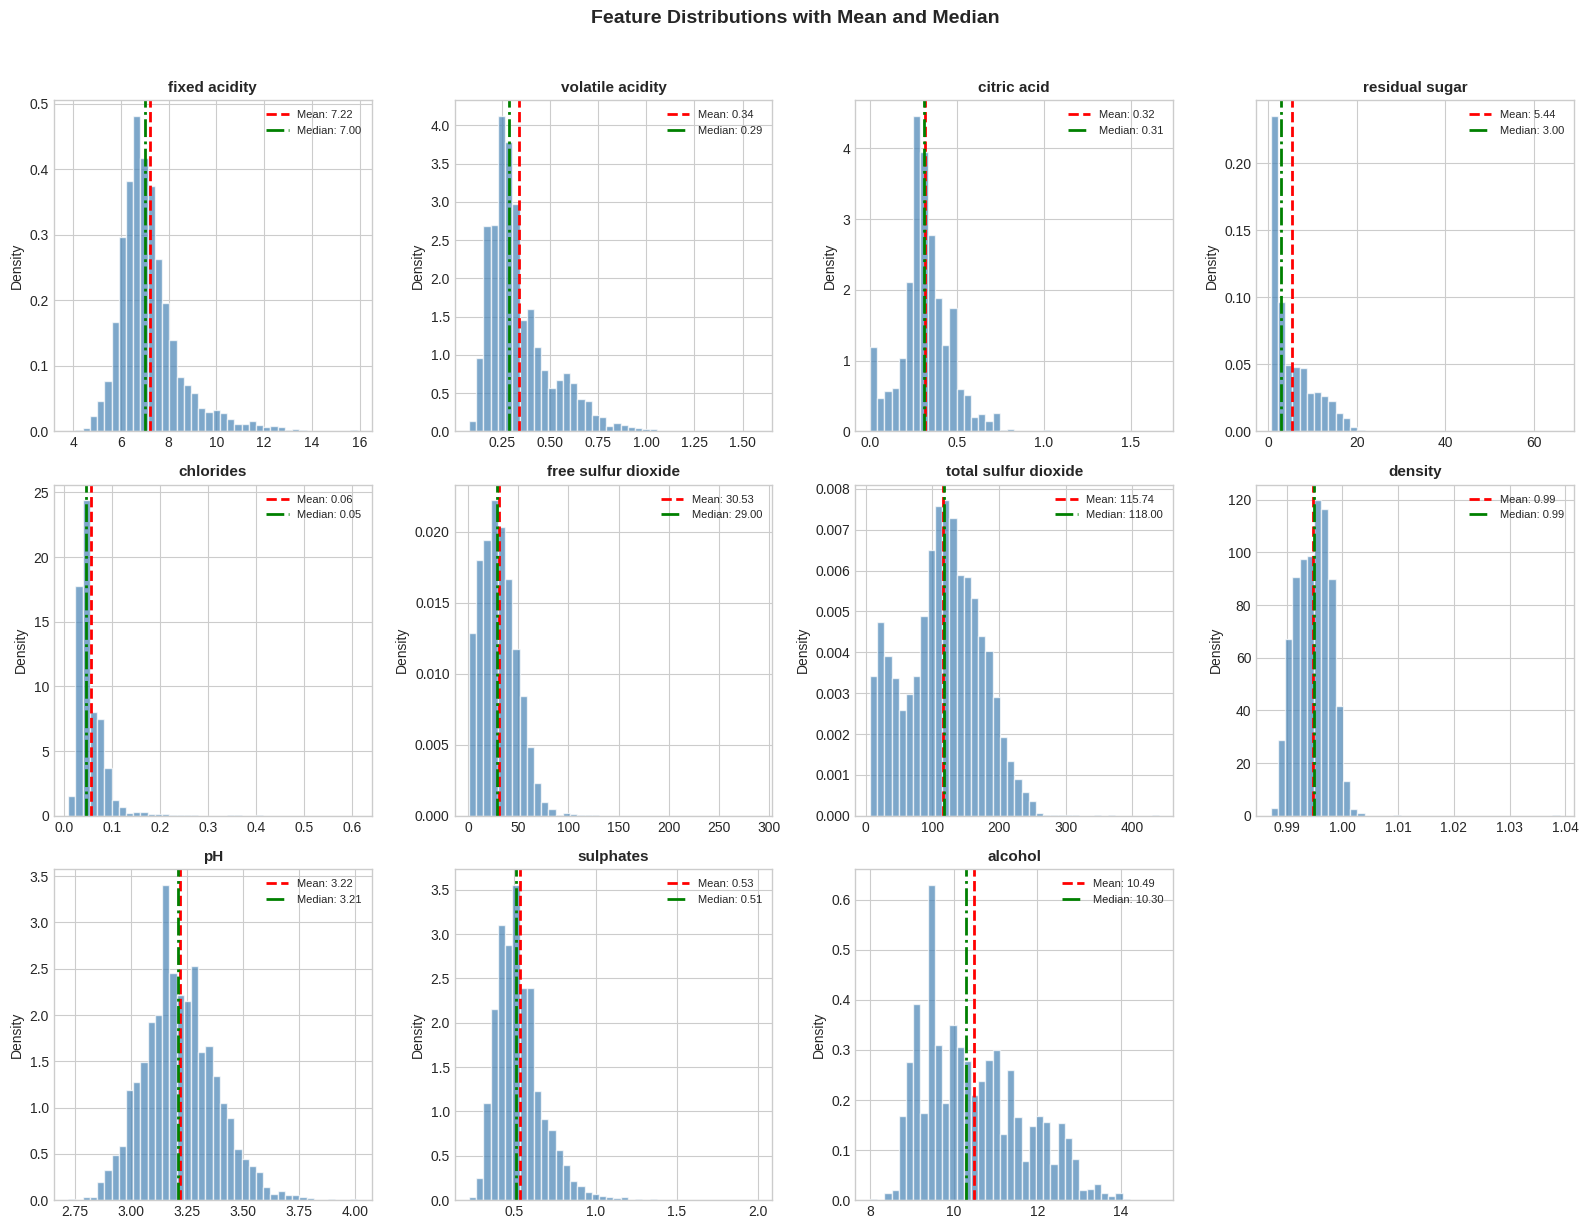

Figure saved: winequality_preprocessing/02_feature_distributions.png


In [13]:
feature_cols = [col for col in numeric_cols if col != 'quality']

n_features = len(feature_cols)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]

    ax.hist(df[col], bins=40, color='steelblue', edgecolor='white', alpha=0.7, density=True)

    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='-.', linewidth=2, label=f'Median: {median_val:.2f}')

    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8, loc='upper right')

for idx in range(len(feature_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature Distributions with Mean and Median', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/02_feature_distributions.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/02_feature_distributions.png')

### 3.6 Correlation Analysis

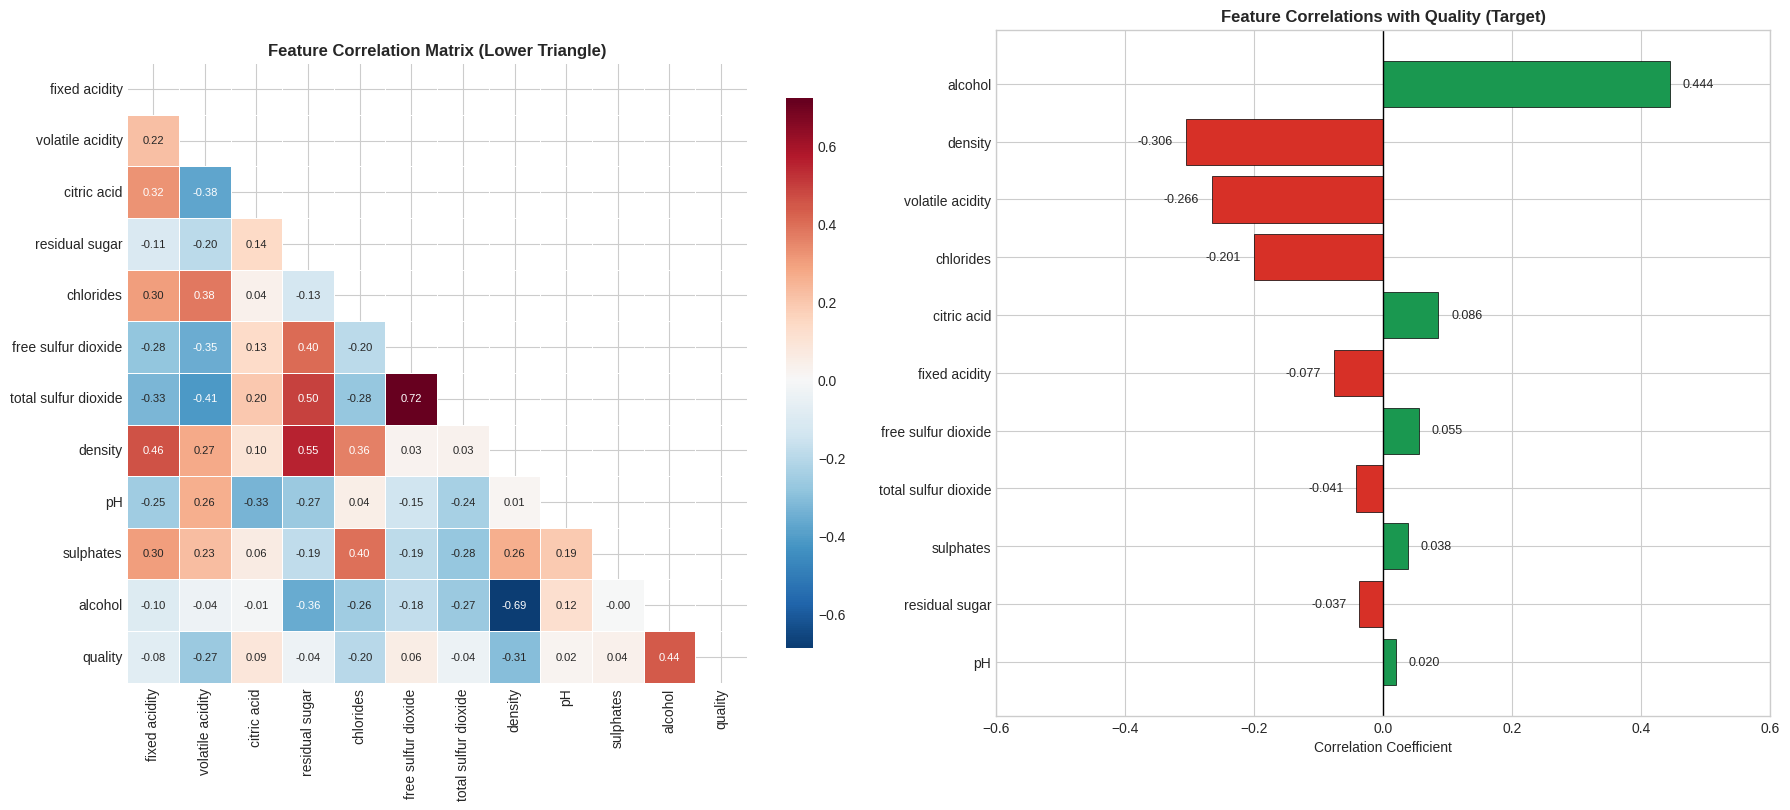

Figure saved: winequality_preprocessing/03_correlation_analysis.png


In [14]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, linewidths=0.5, square=True, cbar_kws={'shrink': 0.8},
            ax=axes[0], annot_kws={'size': 8})
axes[0].set_title('Feature Correlation Matrix (Lower Triangle)', fontsize=12, fontweight='bold')

quality_corr = correlation_matrix['quality'].drop('quality').sort_values(key=abs, ascending=True)
colors = ['#d73027' if x < 0 else '#1a9850' for x in quality_corr.values]
bars = axes[1].barh(quality_corr.index, quality_corr.values, color=colors, edgecolor='black', linewidth=0.5)
axes[1].axvline(x=0, color='black', linewidth=1)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].set_title('Feature Correlations with Quality (Target)', fontsize=12, fontweight='bold')
axes[1].set_xlim(-0.6, 0.6)

for bar, val in zip(bars, quality_corr.values):
    x_pos = val + 0.02 if val >= 0 else val - 0.02
    ha = 'left' if val >= 0 else 'right'
    axes[1].text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
                 va='center', ha=ha, fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/03_correlation_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/03_correlation_analysis.png')

In [15]:
print('Feature Correlations with Quality (sorted by absolute value):')
print('-' * 50)
quality_correlations = correlation_matrix['quality'].drop('quality').sort_values(key=abs, ascending=False)

for feature, corr in quality_correlations.items():
    strength = 'Strong' if abs(corr) > 0.3 else 'Moderate' if abs(corr) > 0.15 else 'Weak'
    direction = 'Positive' if corr > 0 else 'Negative'
    print(f'  {feature}: {corr:.4f} ({strength} {direction})')

Feature Correlations with Quality (sorted by absolute value):
--------------------------------------------------
  alcohol: 0.4443 (Strong Positive)
  density: -0.3059 (Strong Negative)
  volatile acidity: -0.2657 (Moderate Negative)
  chlorides: -0.2007 (Moderate Negative)
  citric acid: 0.0855 (Weak Positive)
  fixed acidity: -0.0767 (Weak Negative)
  free sulfur dioxide: 0.0555 (Weak Positive)
  total sulfur dioxide: -0.0414 (Weak Negative)
  sulphates: 0.0385 (Weak Positive)
  residual sugar: -0.0370 (Weak Negative)
  pH: 0.0195 (Weak Positive)


### 3.7 Outlier Detection with Boxplots

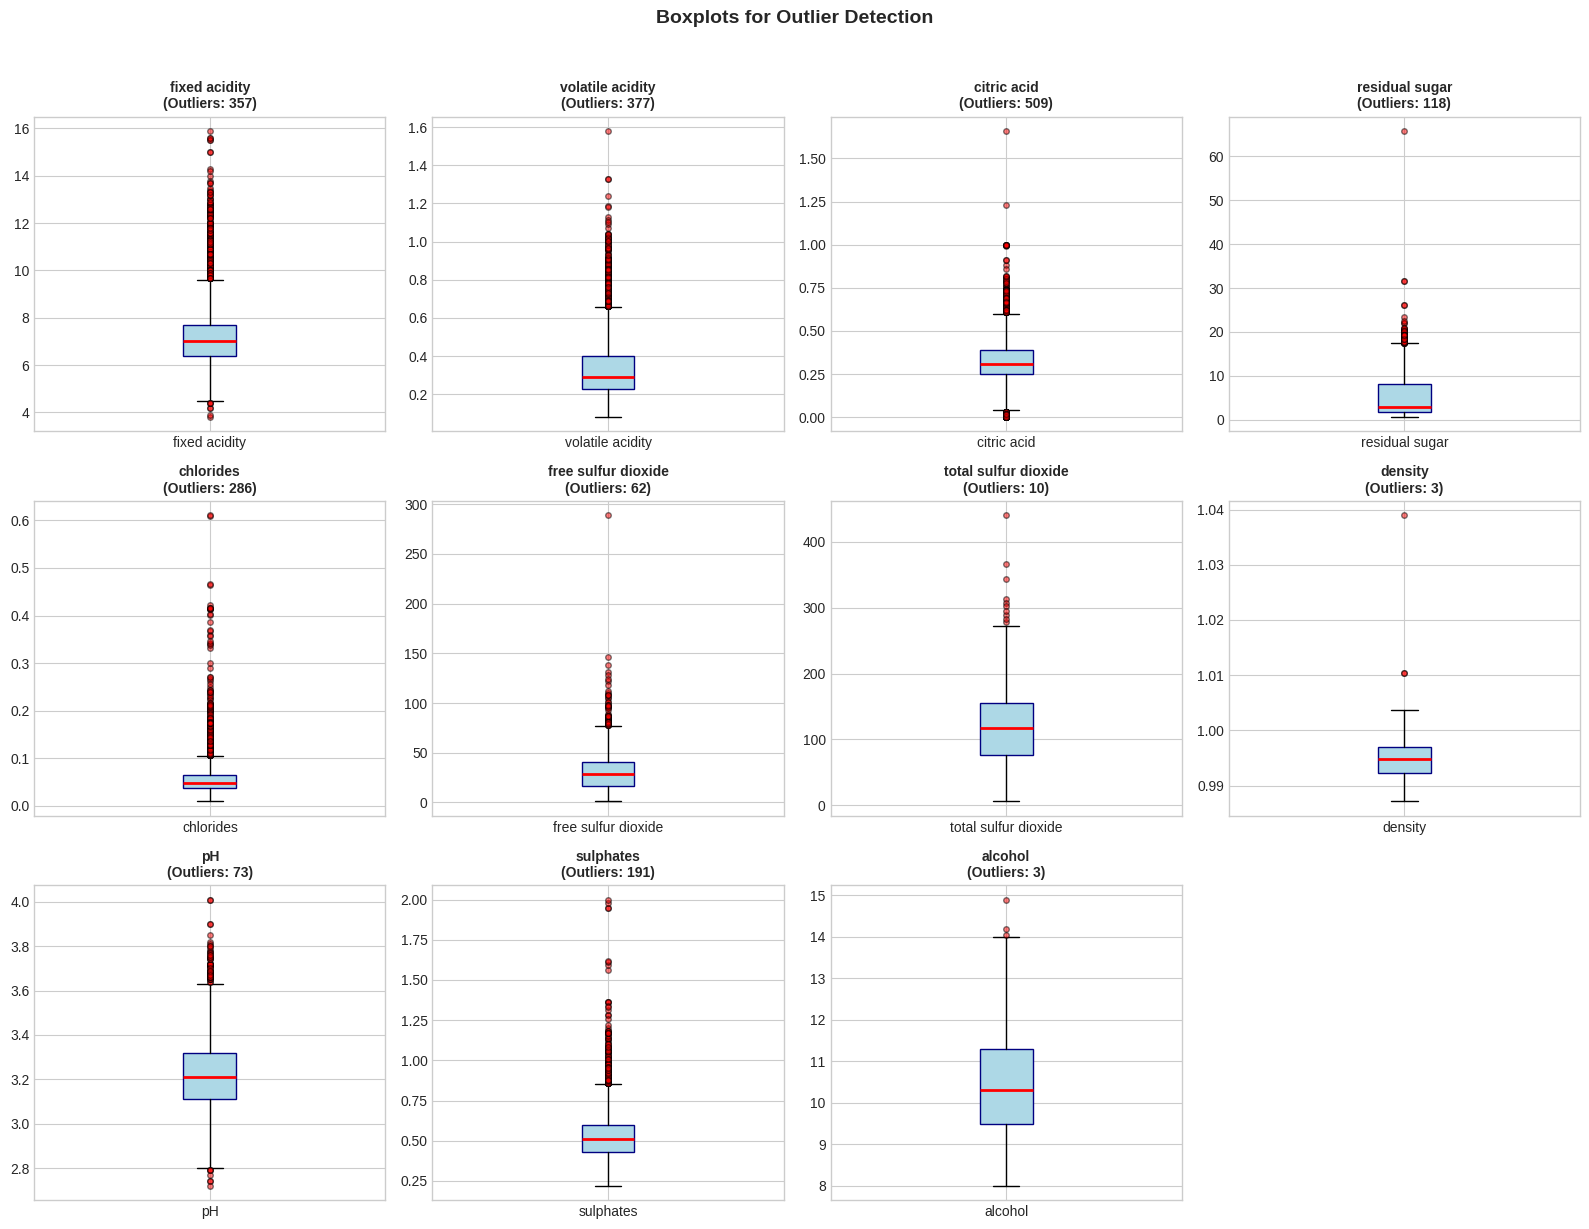

Figure saved: winequality_preprocessing/04_boxplots_outliers.png


In [16]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

outlier_counts = {}

for idx, col in enumerate(feature_cols):
    ax = axes[idx]

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_counts[col] = len(outliers)

    bp = ax.boxplot(df[col], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='navy'),
                    medianprops=dict(color='red', linewidth=2),
                    flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))

    ax.set_title(f'{col}\n(Outliers: {len(outliers)})', fontsize=10, fontweight='bold')
    ax.set_xticklabels([col])

for idx in range(len(feature_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Boxplots for Outlier Detection', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/04_boxplots_outliers.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/04_boxplots_outliers.png')

In [17]:
print('Outlier Summary (using IQR method):')
print('-' * 50)
outlier_df = pd.DataFrame({
    'Feature': list(outlier_counts.keys()),
    'Outlier Count': list(outlier_counts.values()),
    'Percentage (%)': [count/len(df)*100 for count in outlier_counts.values()]
}).sort_values('Outlier Count', ascending=False)

print(outlier_df.to_string(index=False))
print(f'\nTotal outlier instances: {sum(outlier_counts.values())}')

Outlier Summary (using IQR method):
--------------------------------------------------
             Feature  Outlier Count  Percentage (%)
         citric acid            509          7.8344
    volatile acidity            377          5.8027
       fixed acidity            357          5.4948
           chlorides            286          4.4020
           sulphates            191          2.9398
      residual sugar            118          1.8162
                  pH             73          1.1236
 free sulfur dioxide             62          0.9543
total sulfur dioxide             10          0.1539
             density              3          0.0462
             alcohol              3          0.0462

Total outlier instances: 1989


### 3.8 Feature Comparison by Wine Type

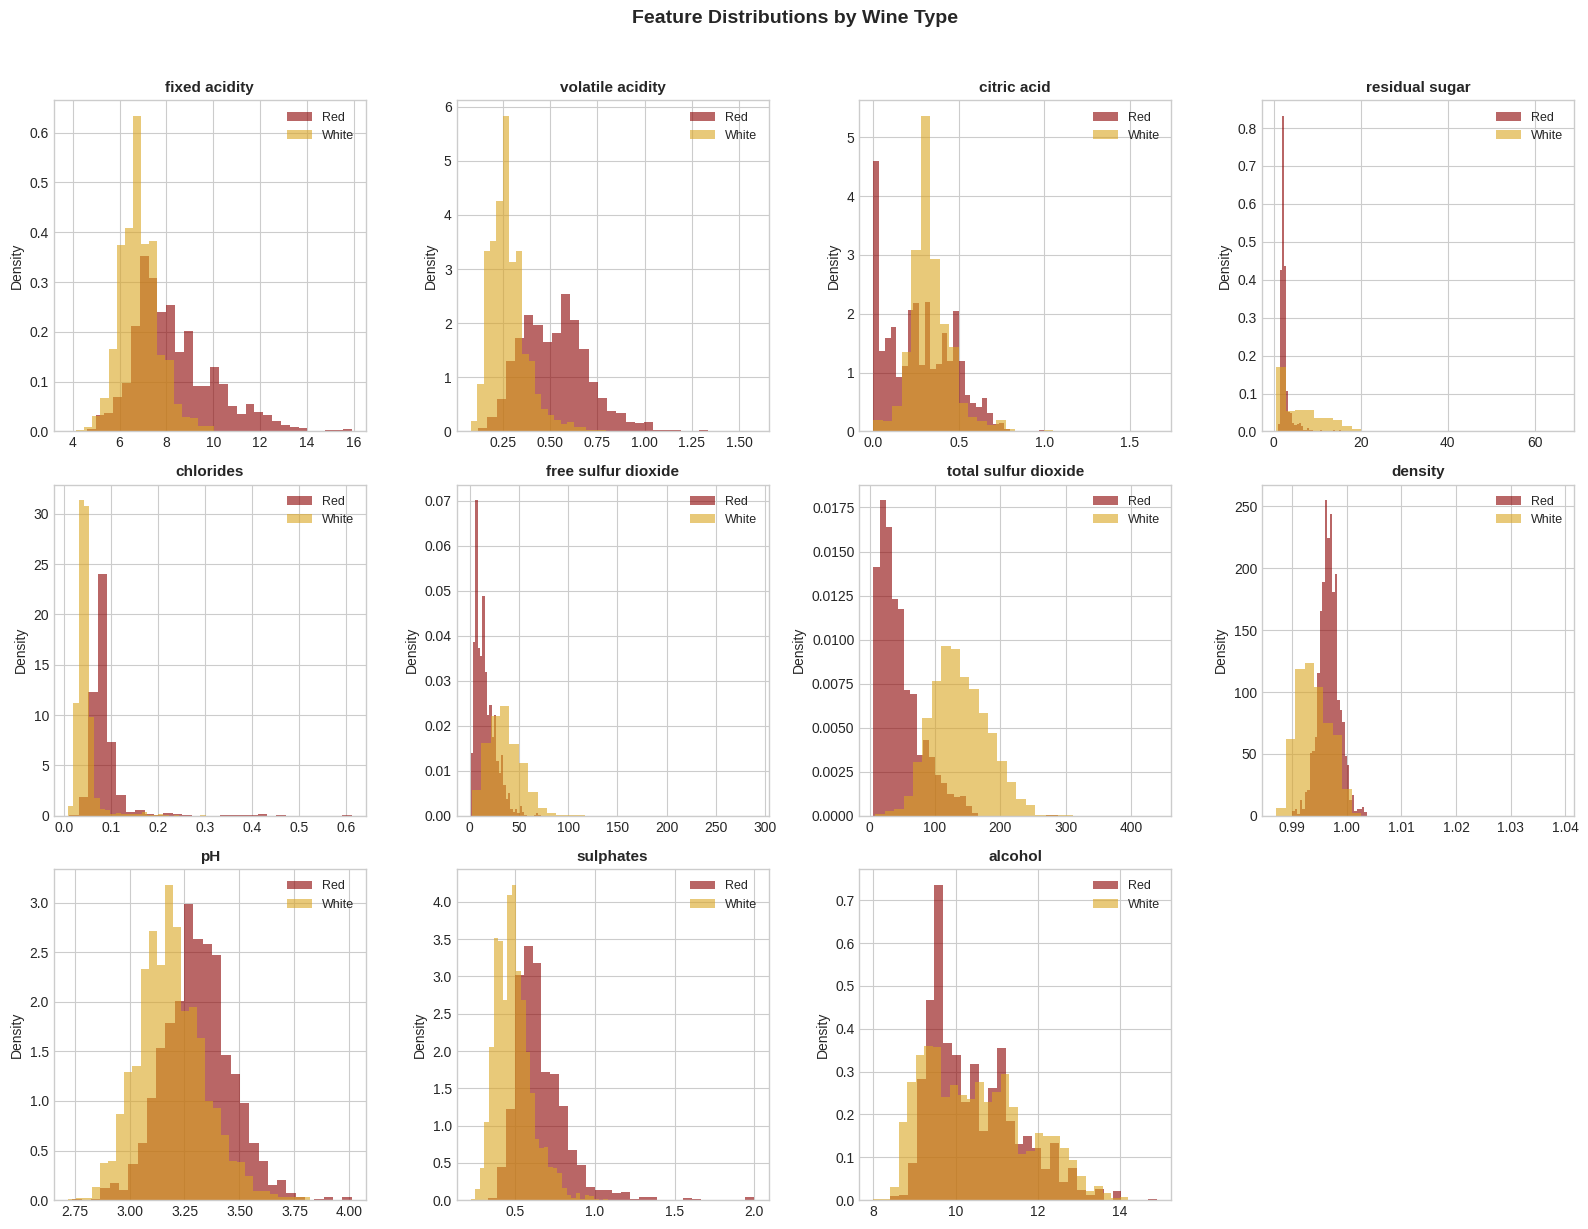

Figure saved: winequality_preprocessing/05_features_by_wine_type.png


In [18]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]

    red_data = df[df['wine_type'] == 'red'][col]
    white_data = df[df['wine_type'] == 'white'][col]

    ax.hist(red_data, bins=30, alpha=0.6, color='#8B0000', label='Red', density=True)
    ax.hist(white_data, bins=30, alpha=0.6, color='#DAA520', label='White', density=True)

    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.set_ylabel('Density')

for idx in range(len(feature_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Feature Distributions by Wine Type', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{output_dir}/05_features_by_wine_type.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/05_features_by_wine_type.png')

In [19]:
print('Mean Feature Values by Wine Type:')
print('-' * 60)
comparison = df.groupby('wine_type')[feature_cols].mean().T
comparison['Difference'] = comparison['red'] - comparison['white']
comparison['% Difference'] = (comparison['Difference'] / comparison['white'] * 100).round(2)
comparison

Mean Feature Values by Wine Type:
------------------------------------------------------------


wine_type,red,white,Difference,% Difference
fixed acidity,8.3196,6.8548,1.4648,21.3700
volatile acidity,0.5278,0.2782,0.2496,89.7000
citric acid,0.2710,0.3342,-0.0632,-18.9200
residual sugar,2.5388,6.3914,-3.8526,-60.2800
chlorides,0.0875,0.0458,0.0417,91.0900
free sulfur dioxide,15.8749,35.3081,-19.4332,-55.0400
total sulfur dioxide,46.4678,138.3607,-91.8929,-66.4200
density,0.9967,0.9940,0.0027,0.2700
pH,3.3111,3.1883,0.1228,3.8500
sulphates,0.6581,0.4898,0.1683,34.3600


### 3.9 Pairplot for Key Features

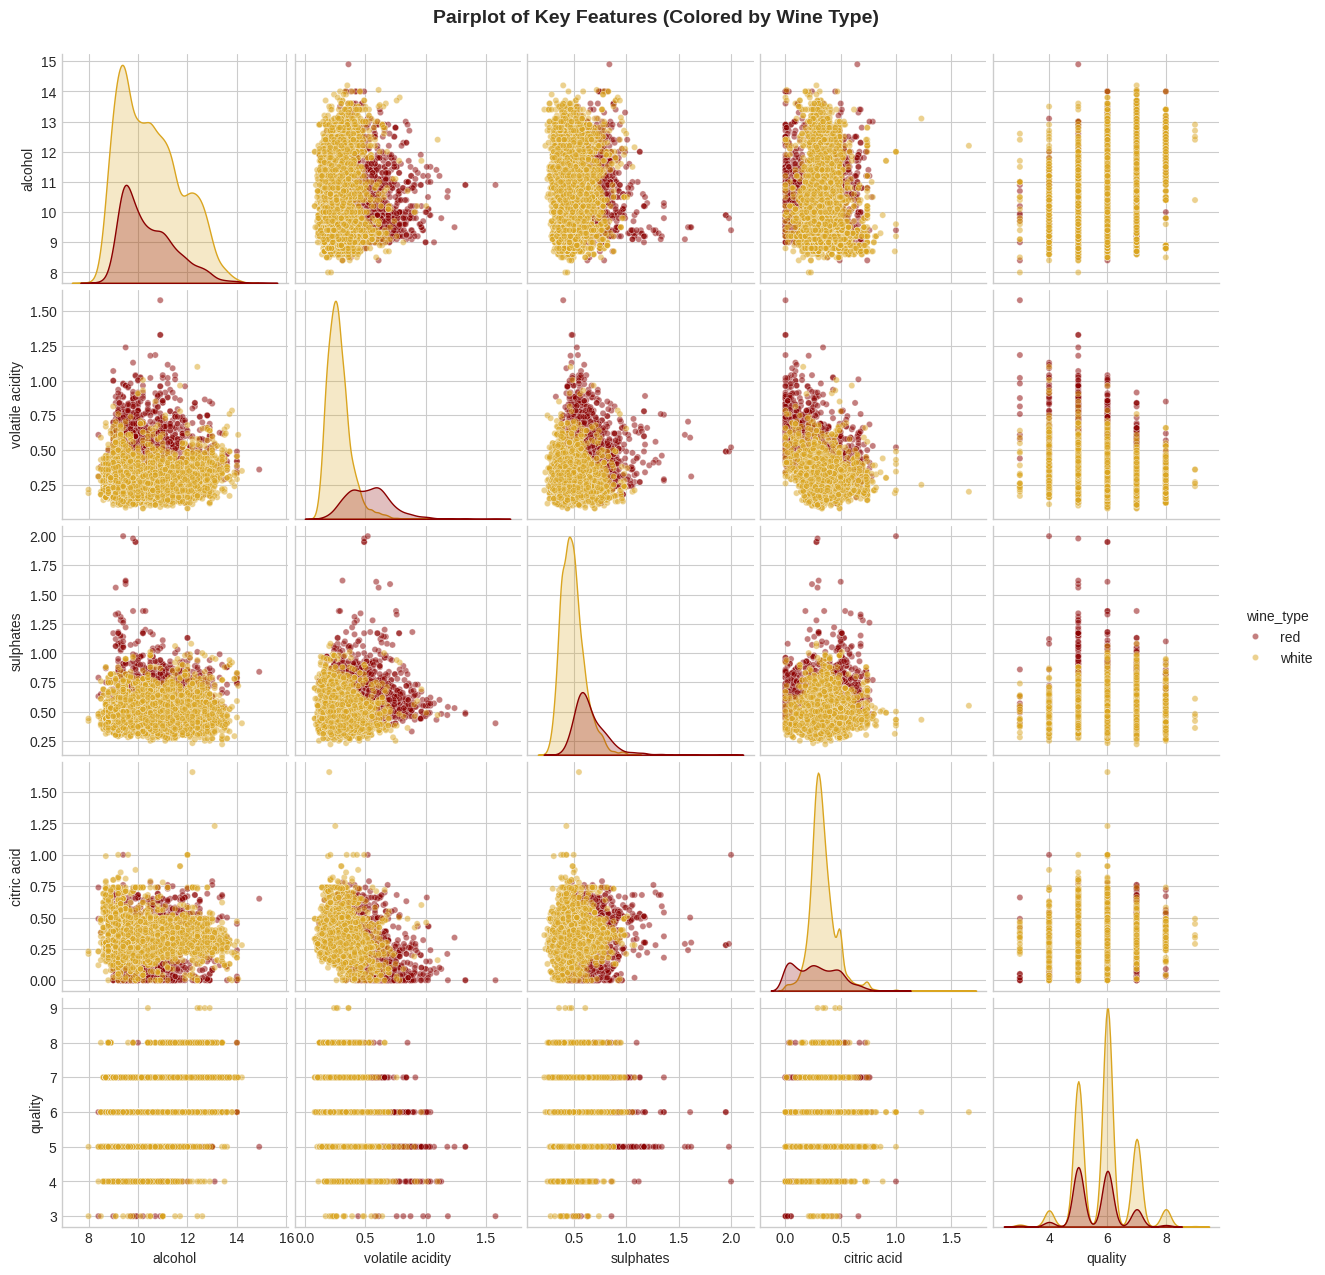

Figure saved: winequality_preprocessing/06_pairplot_key_features.png


In [20]:
key_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'quality']

g = sns.pairplot(df[key_features + ['wine_type']], hue='wine_type',
                 palette={'red': '#8B0000', 'white': '#DAA520'},
                 diag_kind='kde', plot_kws={'alpha': 0.5, 's': 20},
                 height=2.5)
g.fig.suptitle('Pairplot of Key Features (Colored by Wine Type)', y=1.02, fontsize=14, fontweight='bold')

plt.savefig(f'{output_dir}/06_pairplot_key_features.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/06_pairplot_key_features.png')

---
## 4. Data Preprocessing

Tahap preprocessing meliputi:
1. Penghapusan data duplikat
2. Feature Engineering (pembuatan fitur baru)
3. Encoding variabel kategorikal
4. Penanganan outlier menggunakan IQR capping

### 4.1 Remove Duplicates

In [21]:
initial_rows = len(df)
df_clean = df.drop_duplicates().reset_index(drop=True)
removed_duplicates = initial_rows - len(df_clean)

print('Duplicate Removal Results:')
print('-' * 50)
print(f'  Initial rows: {initial_rows:,}')
print(f'  Duplicates removed: {removed_duplicates:,}')
print(f'  Remaining rows: {len(df_clean):,}')
print(f'  Reduction: {(removed_duplicates/initial_rows)*100:.2f}%')

Duplicate Removal Results:
--------------------------------------------------
  Initial rows: 6,497
  Duplicates removed: 1,177
  Remaining rows: 5,320
  Reduction: 18.12%


### 4.2 Feature Engineering

In [22]:
print('Creating new features...')

def create_quality_category(quality):
    if quality <= 4:
        return 'low'
    elif quality <= 6:
        return 'medium'
    else:
        return 'high'

df_clean['quality_category'] = df_clean['quality'].apply(create_quality_category)

df_clean['total_acidity'] = df_clean['fixed acidity'] + df_clean['volatile acidity']

df_clean['bound_sulfur_dioxide'] = df_clean['total sulfur dioxide'] - df_clean['free sulfur dioxide']

df_clean['sugar_to_alcohol'] = df_clean['residual sugar'] / (df_clean['alcohol'] + 0.001)

df_clean['density_alcohol_ratio'] = df_clean['density'] / (df_clean['alcohol'] + 0.001)

df_clean['free_sulfur_ratio'] = df_clean['free sulfur dioxide'] / (df_clean['total sulfur dioxide'] + 0.001)

df_clean['acidity_to_pH'] = df_clean['total_acidity'] / (df_clean['pH'] + 0.001)

print('\nNew Features Created:')
print('-' * 60)
new_features = [
    ('quality_category', 'Categorical version of quality (low/medium/high)'),
    ('total_acidity', 'Sum of fixed and volatile acidity'),
    ('bound_sulfur_dioxide', 'Total minus free sulfur dioxide'),
    ('sugar_to_alcohol', 'Ratio of residual sugar to alcohol'),
    ('density_alcohol_ratio', 'Ratio of density to alcohol'),
    ('free_sulfur_ratio', 'Ratio of free to total sulfur dioxide'),
    ('acidity_to_pH', 'Ratio of total acidity to pH')
]

for feature, description in new_features:
    print(f'  {feature}: {description}')

Creating new features...

New Features Created:
------------------------------------------------------------
  quality_category: Categorical version of quality (low/medium/high)
  total_acidity: Sum of fixed and volatile acidity
  bound_sulfur_dioxide: Total minus free sulfur dioxide
  sugar_to_alcohol: Ratio of residual sugar to alcohol
  density_alcohol_ratio: Ratio of density to alcohol
  free_sulfur_ratio: Ratio of free to total sulfur dioxide
  acidity_to_pH: Ratio of total acidity to pH


Quality Category Distribution:
quality_category
medium    4075
high      1009
low        236
Name: count, dtype: int64


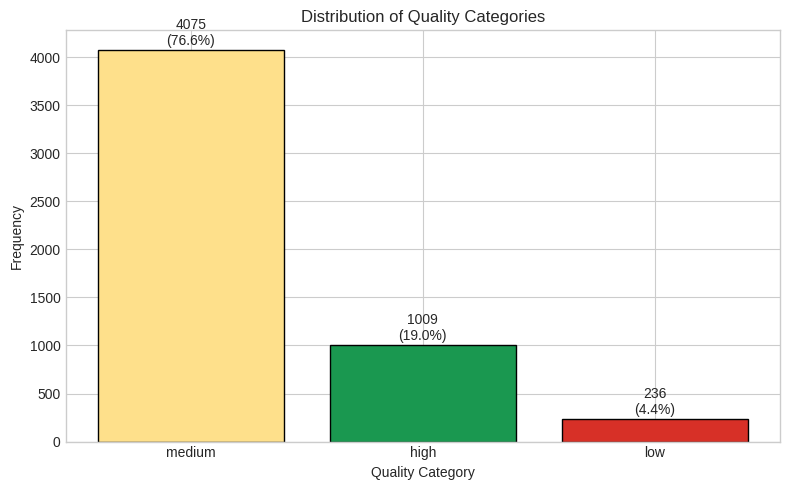

Figure saved: winequality_preprocessing/07_quality_categories.png


In [23]:
print('Quality Category Distribution:')
quality_cat_dist = df_clean['quality_category'].value_counts()
print(quality_cat_dist)

fig, ax = plt.subplots(figsize=(8, 5))
colors = {'low': '#d73027', 'medium': '#fee08b', 'high': '#1a9850'}
bars = ax.bar(quality_cat_dist.index, quality_cat_dist.values,
              color=[colors[cat] for cat in quality_cat_dist.index], edgecolor='black')
ax.set_xlabel('Quality Category')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Quality Categories')

for bar, count in zip(bars, quality_cat_dist.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count}\n({count/len(df_clean)*100:.1f}%)', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{output_dir}/07_quality_categories.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/07_quality_categories.png')

In [24]:
print('Updated Dataset Shape:', df_clean.shape)
print('\nUpdated Columns:')
print(df_clean.columns.tolist())

Updated Dataset Shape: (5320, 20)

Updated Columns:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'wine_type', 'quality_category', 'total_acidity', 'bound_sulfur_dioxide', 'sugar_to_alcohol', 'density_alcohol_ratio', 'free_sulfur_ratio', 'acidity_to_pH']


In [25]:
df_clean.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_category,total_acidity,bound_sulfur_dioxide,sugar_to_alcohol,density_alcohol_ratio,free_sulfur_ratio,acidity_to_pH
0,7.4000,0.7000,0.0000,1.9000,0.0760,11.0000,34.0000,0.9978,3.5100,0.5600,9.4000,5,red,medium,8.1000,23.0000,0.2021,0.1061,0.3235,2.3070
1,7.8000,0.8800,0.0000,2.6000,0.0980,25.0000,67.0000,0.9968,3.2000,0.6800,9.8000,5,red,medium,8.6800,42.0000,0.2653,0.1017,0.3731,2.7117
2,7.8000,0.7600,0.0400,2.3000,0.0920,15.0000,54.0000,0.9970,3.2600,0.6500,9.8000,5,red,medium,8.5600,39.0000,0.2347,0.1017,0.2778,2.6250
3,11.2000,0.2800,0.5600,1.9000,0.0750,17.0000,60.0000,0.9980,3.1600,0.5800,9.8000,6,red,medium,11.4800,43.0000,0.1939,0.1018,0.2833,3.6318
4,7.4000,0.6600,0.0000,1.8000,0.0750,13.0000,40.0000,0.9978,3.5100,0.5600,9.4000,5,red,medium,8.0600,27.0000,0.1915,0.1061,0.3250,2.2956


### 4.3 Encode Categorical Variables

In [26]:
le_wine_type = LabelEncoder()
df_clean['wine_type_encoded'] = le_wine_type.fit_transform(df_clean['wine_type'])

le_quality_cat = LabelEncoder()
df_clean['quality_category_encoded'] = le_quality_cat.fit_transform(df_clean['quality_category'])

print('Encoding Results:')
print('-' * 50)
print('wine_type encoding:')
for cls, code in zip(le_wine_type.classes_, range(len(le_wine_type.classes_))):
    print(f'  {cls} -> {code}')

print('\nquality_category encoding:')
for cls, code in zip(le_quality_cat.classes_, range(len(le_quality_cat.classes_))):
    print(f'  {cls} -> {code}')

Encoding Results:
--------------------------------------------------
wine_type encoding:
  red -> 0
  white -> 1

quality_category encoding:
  high -> 0
  low -> 1
  medium -> 2


### 4.4 Handle Outliers using IQR Capping

In [27]:
def cap_outliers_iqr(series, multiplier=1.5):
    """
    Cap outliers using IQR method.
    Values below Q1 - multiplier*IQR are set to lower bound.
    Values above Q3 + multiplier*IQR are set to upper bound.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    n_lower = (series < lower_bound).sum()
    n_upper = (series > upper_bound).sum()

    return series.clip(lower=lower_bound, upper=upper_bound), n_lower, n_upper

outlier_features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'sulphates', 'total_acidity', 'bound_sulfur_dioxide', 'sugar_to_alcohol',
    'density_alcohol_ratio', 'free_sulfur_ratio', 'acidity_to_pH'
]

capping_results = []

print('Outlier Capping Results:')
print('-' * 60)

for col in outlier_features:
    if col in df_clean.columns:
        df_clean[col], n_lower, n_upper = cap_outliers_iqr(df_clean[col])
        total_capped = n_lower + n_upper
        if total_capped > 0:
            print(f'  {col}: {total_capped} values capped (lower: {n_lower}, upper: {n_upper})')
            capping_results.append({'feature': col, 'lower_capped': n_lower, 'upper_capped': n_upper})

print(f'\nTotal features processed: {len(outlier_features)}')
print(f'Features with outliers capped: {len(capping_results)}')

Outlier Capping Results:
------------------------------------------------------------
  fixed acidity: 304 values capped (lower: 7, upper: 297)
  volatile acidity: 279 values capped (lower: 0, upper: 279)
  citric acid: 143 values capped (lower: 0, upper: 143)
  residual sugar: 141 values capped (lower: 0, upper: 141)
  chlorides: 237 values capped (lower: 0, upper: 237)
  free sulfur dioxide: 44 values capped (lower: 0, upper: 44)
  total sulfur dioxide: 10 values capped (lower: 0, upper: 10)
  density: 3 values capped (lower: 0, upper: 3)
  sulphates: 163 values capped (lower: 0, upper: 163)
  total_acidity: 294 values capped (lower: 4, upper: 290)
  bound_sulfur_dioxide: 16 values capped (lower: 0, upper: 16)
  sugar_to_alcohol: 238 values capped (lower: 0, upper: 238)
  free_sulfur_ratio: 175 values capped (lower: 0, upper: 175)
  acidity_to_pH: 246 values capped (lower: 6, upper: 240)

Total features processed: 15
Features with outliers capped: 14


---
## 5. Data Splitting

Dataset dibagi menjadi training set (80%) dan test set (20%) dengan stratified sampling berdasarkan target variable (quality).

In [28]:
feature_columns = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol', 'wine_type_encoded', 'total_acidity',
    'bound_sulfur_dioxide', 'sugar_to_alcohol', 'density_alcohol_ratio',
    'free_sulfur_ratio', 'acidity_to_pH'
]

X = df_clean[feature_columns].copy()
y_regression = df_clean['quality'].copy()
y_classification = df_clean['quality_category_encoded'].copy()

print('Feature and Target Shapes:')
print(f'  X (features): {X.shape}')
print(f'  y_regression (quality score): {y_regression.shape}')
print(f'  y_classification (quality category): {y_classification.shape}')

Feature and Target Shapes:
  X (features): (5320, 18)
  y_regression (quality score): (5320,)
  y_classification (quality category): (5320,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_regression,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_regression
)

_, _, y_train_cls, y_test_cls = train_test_split(
    X, y_classification,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_classification
)

print('Train-Test Split Results:')
print('-' * 50)
print(f'  Training set: {X_train.shape[0]:,} samples ({(1-TEST_SIZE)*100:.0f}%)')
print(f'  Test set: {X_test.shape[0]:,} samples ({TEST_SIZE*100:.0f}%)')
print(f'  Number of features: {X_train.shape[1]}')
print(f'  Random state: {RANDOM_STATE}')

Train-Test Split Results:
--------------------------------------------------
  Training set: 4,256 samples (80%)
  Test set: 1,064 samples (20%)
  Number of features: 18
  Random state: 42


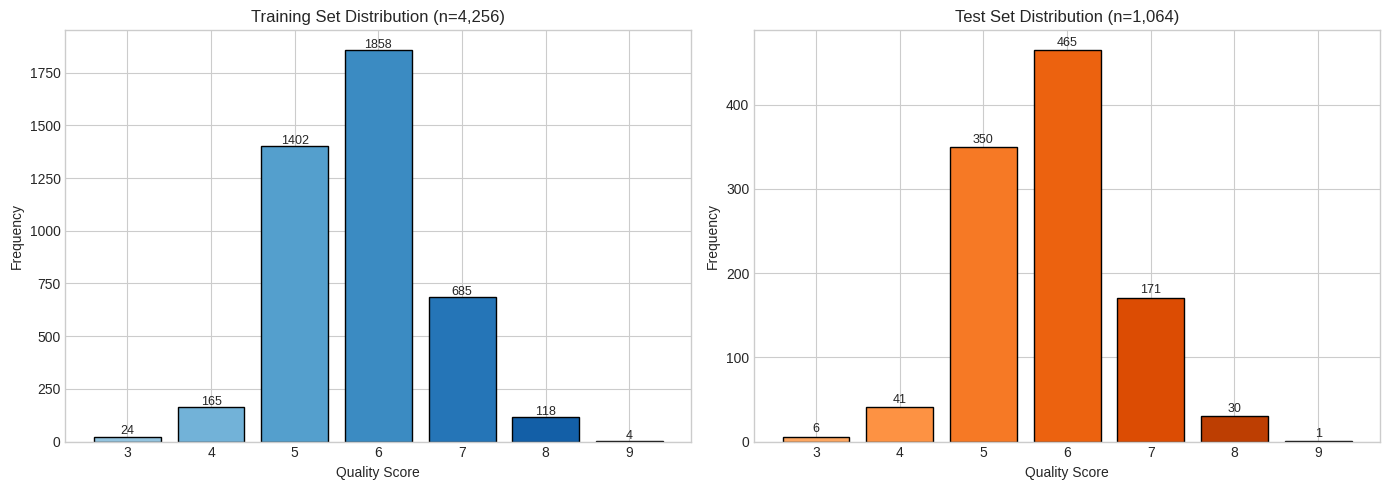

Figure saved: winequality_preprocessing/08_train_test_distribution.png


In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_counts = y_train.value_counts().sort_index()
colors_train = plt.cm.Blues(np.linspace(0.4, 0.9, len(train_counts)))
bars1 = axes[0].bar(train_counts.index.astype(str), train_counts.values, color=colors_train, edgecolor='black')
axes[0].set_xlabel('Quality Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Training Set Distribution (n={len(y_train):,})')
for bar, count in zip(bars1, train_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                 str(count), ha='center', fontsize=9)

test_counts = y_test.value_counts().sort_index()
colors_test = plt.cm.Oranges(np.linspace(0.4, 0.9, len(test_counts)))
bars2 = axes[1].bar(test_counts.index.astype(str), test_counts.values, color=colors_test, edgecolor='black')
axes[1].set_xlabel('Quality Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Test Set Distribution (n={len(y_test):,})')
for bar, count in zip(bars2, test_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(count), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/08_train_test_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/08_train_test_distribution.png')

In [31]:
print('Stratification Verification:')
print('-' * 50)

train_dist = y_train.value_counts(normalize=True).sort_index() * 100
test_dist = y_test.value_counts(normalize=True).sort_index() * 100
original_dist = y_regression.value_counts(normalize=True).sort_index() * 100

verification_df = pd.DataFrame({
    'Original (%)': original_dist,
    'Train (%)': train_dist,
    'Test (%)': test_dist
}).round(2)

print(verification_df)
print('\nStratification preserved: Distribution is consistent across splits')

Stratification Verification:
--------------------------------------------------
         Original (%)  Train (%)  Test (%)
quality                                   
3              0.5600     0.5600    0.5600
4              3.8700     3.8800    3.8500
5             32.9300    32.9400   32.8900
6             43.6700    43.6600   43.7000
7             16.0900    16.0900   16.0700
8              2.7800     2.7700    2.8200
9              0.0900     0.0900    0.0900

Stratification preserved: Distribution is consistent across splits


---
## 6. Feature Scaling

Feature scaling dilakukan menggunakan StandardScaler untuk menormalkan distribusi fitur sehingga memiliki mean=0 dan standard deviation=1.

In [32]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print('Feature Scaling Applied (StandardScaler)')
print('-' * 50)
print('Training set transformation: fit_transform()')
print('Test set transformation: transform()')

Feature Scaling Applied (StandardScaler)
--------------------------------------------------
Training set transformation: fit_transform()
Test set transformation: transform()


In [33]:
print('Scaled Training Data Statistics:')
scaled_stats = X_train_scaled.describe().T[['mean', 'std', 'min', 'max']]
scaled_stats

Scaled Training Data Statistics:


,mean,std,min,max
fixed acidity,-0.0000,1.0001,-2.4712,2.2955
volatile acidity,0.0000,1.0001,-1.7397,2.3222
citric acid,-0.0000,1.0001,-2.2843,2.3385
residual sugar,0.0000,1.0001,-1.0309,2.6372
chlorides,-0.0000,1.0001,-2.0287,2.4725
free sulfur dioxide,0.0000,1.0001,-1.7108,2.8925
total sulfur dioxide,-0.0000,1.0001,-1.8970,2.8187
density,0.0000,1.0001,-2.5540,3.1586
pH,0.0000,1.0001,-3.1428,4.9068
sulphates,-0.0000,1.0001,-2.3534,2.4894


In [34]:
print('Scaler Parameters (Mean and Scale for each feature):')
print('-' * 60)
scaler_params = pd.DataFrame({
    'Feature': feature_columns,
    'Mean': scaler.mean_,
    'Scale (Std)': scaler.scale_
})
scaler_params

Scaler Parameters (Mean and Scale for each feature):
------------------------------------------------------------


,Feature,Mean,Scale (Std)
0,fixed acidity,7.1459,1.0909
1,volatile acidity,0.3370,0.1477
2,citric acid,0.3162,0.1384
3,residual sugar,4.9420,4.2121
4,chlorides,0.0536,0.0220
5,free sulfur dioxide,29.8030,16.8356
6,total sulfur dioxide,113.6511,56.2219
7,density,0.9945,0.0029
8,pH,3.2237,0.1603
9,sulphates,0.5286,0.1311


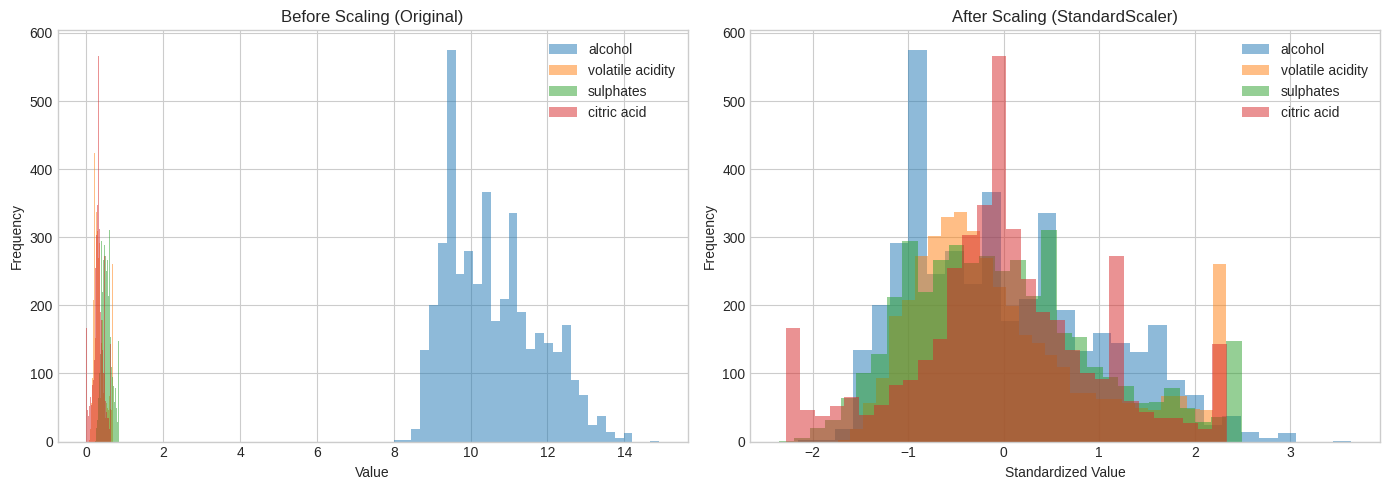

Figure saved: winequality_preprocessing/09_scaling_comparison.png


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sample_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']

for feature in sample_features:
    axes[0].hist(X_train[feature], bins=30, alpha=0.5, label=feature)
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Before Scaling (Original)')
axes[0].legend()

for feature in sample_features:
    axes[1].hist(X_train_scaled[feature], bins=30, alpha=0.5, label=feature)
axes[1].set_xlabel('Standardized Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('After Scaling (StandardScaler)')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/09_scaling_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f'Figure saved: {output_dir}/09_scaling_comparison.png')

---
## 7. Save Preprocessed Data dan Artifacts

Menyimpan data hasil preprocessing dan artifacts (scaler, encoder, feature list) untuk digunakan dalam tahap modeling.

In [36]:
print('Saving preprocessed data and artifacts...')
print('-' * 50)

X_train_scaled.to_csv(f'{output_dir}/X_train.csv', index=False)
X_test_scaled.to_csv(f'{output_dir}/X_test.csv', index=False)
print('Saved: X_train.csv, X_test.csv')

y_train.to_csv(f'{output_dir}/y_train.csv', index=False, header=['quality'])
y_test.to_csv(f'{output_dir}/y_test.csv', index=False, header=['quality'])
print('Saved: y_train.csv, y_test.csv (regression targets)')

y_train_cls.to_csv(f'{output_dir}/y_train_cls.csv', index=False, header=['quality_category'])
y_test_cls.to_csv(f'{output_dir}/y_test_cls.csv', index=False, header=['quality_category'])
print('Saved: y_train_cls.csv, y_test_cls.csv (classification targets)')

df_clean.to_csv(f'{output_dir}/winequality_preprocessed_full.csv', index=False)
print('Saved: winequality_preprocessed_full.csv')

Saving preprocessed data and artifacts...
--------------------------------------------------
Saved: X_train.csv, X_test.csv
Saved: y_train.csv, y_test.csv (regression targets)
Saved: y_train_cls.csv, y_test_cls.csv (classification targets)
Saved: winequality_preprocessed_full.csv


In [37]:
joblib.dump(scaler, f'{output_dir}/scaler.pkl')
print('Saved: scaler.pkl')

joblib.dump(le_wine_type, f'{output_dir}/label_encoder_wine_type.pkl')
print('Saved: label_encoder_wine_type.pkl')

joblib.dump(le_quality_cat, f'{output_dir}/label_encoder_quality_category.pkl')
print('Saved: label_encoder_quality_category.pkl')

joblib.dump(feature_columns, f'{output_dir}/feature_columns.pkl')
print('Saved: feature_columns.pkl')

Saved: scaler.pkl
Saved: label_encoder_wine_type.pkl
Saved: label_encoder_quality_category.pkl
Saved: feature_columns.pkl


In [38]:
preprocessing_summary = {
    'metadata': {
        'author': 'Syifa Fauziah',
        'course': 'Membangun Sistem Machine Learning - Dicoding',
        'dataset': 'UCI Wine Quality',
        'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'python_version': '3.9+'
    },
    'data_statistics': {
        'original_samples': int(len(df)),
        'red_wine_samples': int(len(df_red)),
        'white_wine_samples': int(len(df_white)),
        'duplicates_removed': int(removed_duplicates),
        'samples_after_cleaning': int(len(df_clean))
    },
    'split_info': {
        'train_samples': int(len(X_train)),
        'test_samples': int(len(X_test)),
        'train_ratio': float(1 - TEST_SIZE),
        'test_ratio': float(TEST_SIZE),
        'random_state': RANDOM_STATE,
        'stratified': True
    },
    'feature_info': {
        'n_features': len(feature_columns),
        'original_features': 11,
        'engineered_features': len(feature_columns) - 12,
        'feature_names': feature_columns
    },
    'target_info': {
        'regression_target': 'quality',
        'classification_target': 'quality_category',
        'quality_min': int(y_regression.min()),
        'quality_max': int(y_regression.max()),
        'quality_mean': float(y_regression.mean()),
        'quality_std': float(y_regression.std())
    },
    'preprocessing_steps': [
        'Load data from UCI repository',
        'Combine red and white wine datasets',
        'Remove duplicate rows',
        'Feature engineering (7 new features)',
        'Encode categorical variables',
        'Cap outliers using IQR method',
        'Train-test split (80/20, stratified)',
        'StandardScaler normalization'
    ],
    'output_files': {
        'training_features': 'X_train.csv',
        'test_features': 'X_test.csv',
        'training_target_regression': 'y_train.csv',
        'test_target_regression': 'y_test.csv',
        'training_target_classification': 'y_train_cls.csv',
        'test_target_classification': 'y_test_cls.csv',
        'full_preprocessed': 'winequality_preprocessed_full.csv',
        'scaler': 'scaler.pkl',
        'wine_type_encoder': 'label_encoder_wine_type.pkl',
        'quality_category_encoder': 'label_encoder_quality_category.pkl',
        'feature_list': 'feature_columns.pkl'
    }
}

with open(f'{output_dir}/preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print('\nSaved: preprocessing_summary.json')


Saved: preprocessing_summary.json


In [39]:
print('\nOutput Directory Contents:')
print('-' * 50)
total_size = 0
for f in sorted(os.listdir(output_dir)):
    filepath = f'{output_dir}/{f}'
    size = os.path.getsize(filepath)
    total_size += size
    print(f'  {f}: {size/1024:.1f} KB')

print(f'\nTotal size: {total_size/1024:.1f} KB ({total_size/1024/1024:.2f} MB)')


Output Directory Contents:
--------------------------------------------------
  01_quality_distribution.png: 90.5 KB
  02_feature_distributions.png: 221.7 KB
  03_correlation_analysis.png: 201.5 KB
  04_boxplots_outliers.png: 203.5 KB
  05_features_by_wine_type.png: 173.2 KB
  06_pairplot_key_features.png: 1277.6 KB
  07_quality_categories.png: 44.6 KB
  08_train_test_distribution.png: 56.8 KB
  09_scaling_comparison.png: 55.7 KB
  X_test.csv: 367.2 KB
  X_train.csv: 1468.8 KB
  feature_columns.pkl: 0.3 KB
  label_encoder_quality_category.pkl: 0.5 KB
  label_encoder_wine_type.pkl: 0.5 KB
  preprocessing_summary.json: 2.2 KB
  scaler.pkl: 1.6 KB
  winequality_preprocessed_full.csv: 865.7 KB
  y_test.csv: 2.1 KB
  y_test_cls.csv: 2.1 KB
  y_train.csv: 8.3 KB
  y_train_cls.csv: 8.3 KB

Total size: 5052.6 KB (4.93 MB)


---
## 8. Summary dan Kesimpulan

In [40]:
print('=' * 70)
print('PREPROCESSING PIPELINE SUMMARY')
print('=' * 70)

print('\n1. DATA LOADING')
print(f'   - Source: UCI Machine Learning Repository')
print(f'   - Red wine samples: {len(df_red):,}')
print(f'   - White wine samples: {len(df_white):,}')
print(f'   - Total samples: {len(df):,}')

print('\n2. DATA CLEANING')
print(f'   - Duplicates removed: {removed_duplicates:,}')
print(f'   - Final samples: {len(df_clean):,}')

print('\n3. FEATURE ENGINEERING')
print(f'   - Original features: 11')
print(f'   - New features created: {len(feature_columns) - 12}')
print(f'   - Total features: {len(feature_columns)}')

print('\n4. DATA SPLITTING')
print(f'   - Training set: {len(X_train):,} samples ({(1-TEST_SIZE)*100:.0f}%)')
print(f'   - Test set: {len(X_test):,} samples ({TEST_SIZE*100:.0f}%)')
print(f'   - Stratified by: quality score')

print('\n5. FEATURE SCALING')
print(f'   - Method: StandardScaler')
print(f'   - Training set: fit_transform()')
print(f'   - Test set: transform()')

print('\n6. OUTPUT FILES')
print(f'   - Location: {output_dir}/')
print(f'   - Data files: 7 CSV files')
print(f'   - Model artifacts: 4 PKL files')
print(f'   - Visualizations: 9 PNG files')
print(f'   - Summary: 1 JSON file')

print('\n' + '=' * 70)
print('PREPROCESSING COMPLETED SUCCESSFULLY')
print('Data is ready for model training')
print('=' * 70)

PREPROCESSING PIPELINE SUMMARY

1. DATA LOADING
   - Source: UCI Machine Learning Repository
   - Red wine samples: 1,599
   - White wine samples: 4,898
   - Total samples: 6,497

2. DATA CLEANING
   - Duplicates removed: 1,177
   - Final samples: 5,320

3. FEATURE ENGINEERING
   - Original features: 11
   - New features created: 6
   - Total features: 18

4. DATA SPLITTING
   - Training set: 4,256 samples (80%)
   - Test set: 1,064 samples (20%)
   - Stratified by: quality score

5. FEATURE SCALING
   - Method: StandardScaler
   - Training set: fit_transform()
   - Test set: transform()

6. OUTPUT FILES
   - Location: winequality_preprocessing/
   - Data files: 7 CSV files
   - Model artifacts: 4 PKL files
   - Visualizations: 9 PNG files
   - Summary: 1 JSON file

PREPROCESSING COMPLETED SUCCESSFULLY
Data is ready for model training


In [41]:
verification_checks = {
    'No missing values in X_train': X_train_scaled.isnull().sum().sum() == 0,
    'No missing values in X_test': X_test_scaled.isnull().sum().sum() == 0,
    'Train-test dimensions match': X_train_scaled.shape[1] == X_test_scaled.shape[1],
    'y_train matches X_train length': len(y_train) == len(X_train_scaled),
    'y_test matches X_test length': len(y_test) == len(X_test_scaled),
    'Feature scaling applied': abs(X_train_scaled.mean().mean()) < 0.01,
    'All artifacts saved': all(os.path.exists(f'{output_dir}/{f}')
                               for f in ['scaler.pkl', 'X_train.csv', 'y_train.csv'])
}

print('\nFinal Verification Checks:')
print('-' * 50)
all_passed = True
for check, passed in verification_checks.items():
    status = 'PASS' if passed else 'FAIL'
    symbol = '[OK]' if passed else '[X]'
    print(f'  {symbol} {check}: {status}')
    if not passed:
        all_passed = False

print('\n' + '-' * 50)
if all_passed:
    print('All verification checks PASSED')
else:
    print('Some verification checks FAILED - please review')


Final Verification Checks:
--------------------------------------------------
  [OK] No missing values in X_train: PASS
  [OK] No missing values in X_test: PASS
  [OK] Train-test dimensions match: PASS
  [OK] y_train matches X_train length: PASS
  [OK] y_test matches X_test length: PASS
  [OK] Feature scaling applied: PASS
  [OK] All artifacts saved: PASS

--------------------------------------------------
All verification checks PASSED
